<b>Grad-CAM is a technique that helps generate the heat-maps which can assist in highlighting the features in images that a deep learning model uses to predict the label.

By analysing these heat-maps in conjunction with the actual images we are able to derive insight of the inner workings of the models, which otherwise have been more like a black-box. 

Also, with the help of this understanding further tuning and optimisation of the neural networks can be made possible to make our models more robust to noise and improve the accuracy too.</b>

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2" # "0, 1" for multiple

In [3]:
import numpy as np

### Supplying the image and extracted label repositories

In [4]:
# Setting paths for training data, testing data and image dimension size 224x224
TRAIN_DIR = '/media/MyDataStor2/jaybaksh/data/ImageNet/alexnet/train'
TEST_DIR = '/media/MyDataStor2/jaybaksh/data/ImageNet/alexnet/test/'
IMG_SIZE = 224

### Loading the images, text labels and one-hot encoded labels

In [5]:
training_images = np.load('/media/MyDataStor2/jaybaksh/data/ImageNet/new_training_images_RGB.npy')
training_onehot_labels = np.load('/media/MyDataStor2/jaybaksh/data/ImageNet/new_training_onehot_labels_RGB.npy')
training_seq_labels = np.load('/media/MyDataStor2/jaybaksh/data/ImageNet/new_training_seq_labels_RGB.npy')

In [6]:
test_images = np.load('/media/MyDataStor2/jaybaksh/data/ImageNet/new_test_images_RGB.npy')
test_id = np.load('/media/MyDataStor2/jaybaksh/data/ImageNet/new_test_id_RGB.npy')

### The plot function is to showcase a few of the images being accessed by the model

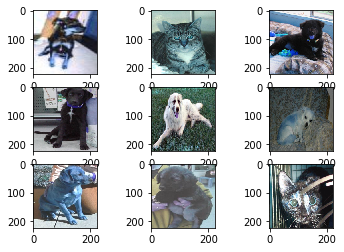

In [7]:
from matplotlib import pyplot as plt

for i,img in enumerate(training_images):
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    if i==8:
        break
        
plt.show()

### The model implementation from keras.

In [8]:
from keras.applications.vgg16 import VGG16

# weights saved in a .h5 file from the model training can be supplied here as parameter
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

Using TensorFlow backend.


In [9]:
from keras.layers import GlobalAveragePooling2D

# get layers and add average pooling layer
vgg_model.layers.pop()
x = vgg_model.layers[-1].output
x = GlobalAveragePooling2D()(x)

In [10]:
from keras.layers import Dense

#output layer
prediction_layer = Dense(2, activation='softmax')(x)

### Loading up the model with input and ouput parameters

In [11]:
from keras import Model

model = Model(inputs=vgg_model.input, outputs=prediction_layer)

In [12]:
# freeze pre-trained model area's layers
for layer in vgg_model.layers:
    layer.trainable = False

### Model fitting on the images

In [13]:
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy

# update the weight that are added
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(training_images, training_onehot_labels)

Epoch 1/1
25000/25000 [==============================] - 86s 3ms/step - loss: 0.4120


In [14]:
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

In [15]:
from keras.optimizers import SGD

# training
model.compile(optimizer=SGD(lr=0.001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_onehot_labels,
          batch_size=32, epochs=5, shuffle=True, validation_split=0.3)

Train on 17500 samples, validate on 7500 samples
Epoch 1/5
17500/17500 [==============================] - 93s 5ms/step - loss: 0.1386 - acc: 0.9448 - val_loss: 0.0896 - val_acc: 0.9640
Epoch 2/5
17500/17500 [==============================] - 92s 5ms/step - loss: 0.0789 - acc: 0.9695 - val_loss: 0.0712 - val_acc: 0.9723
Epoch 3/5
17500/17500 [==============================] - 92s 5ms/step - loss: 0.0554 - acc: 0.9785 - val_loss: 0.0719 - val_acc: 0.9703
Epoch 4/5
17500/17500 [==============================] - 92s 5ms/step - loss: 0.0456 - acc: 0.9841 - val_loss: 0.0648 - val_acc: 0.9760
Epoch 5/5
17500/17500 [==============================] - 92s 5ms/step - loss: 0.0364 - acc: 0.9883 - val_loss: 0.0654 - val_acc: 0.9764


### Running the Grad-CAM on the model output to generate heatmaps

In [20]:
from vis.visualization import visualize_cam

def compare_original_heatmap(i):

    if (int(training_onehot_labels[i][0])) == 1: 
        heat_map = visualize_cam(model, 15, 0, training_images[i])
    else:
        heat_map = visualize_cam(model, 15, 1, training_images[i])

    plt.subplot(1,2,1)
    plt.imshow(training_images[i])
    plt.subplot(1,2,2)
    plt.imshow(heat_map)
    plt.show()

In [21]:
predictions_list = model.predict(test_images, batch_size=32, verbose=1)

12500/12500 [==============================] - 39s 3ms/step


In [47]:
predictions_labels = []

In [51]:
for index in range(predictions_list.shape[0]):
    if (predictions_list[index][0] > predictions_list[index][1]):
        predictions_labels.append('cat')
    else:
        predictions_labels.append('dog')

### Displaying the heat-maps highlighting the relevant features used by model to predict the label

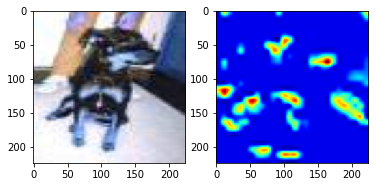

dog


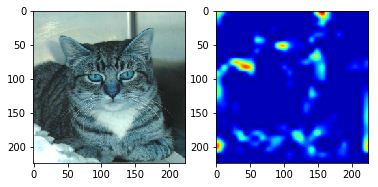

cat


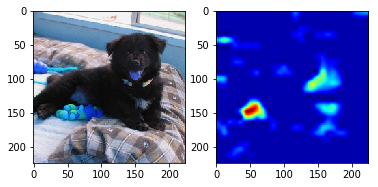

cat


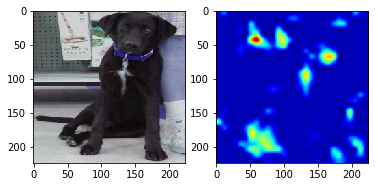

cat


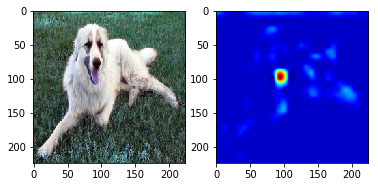

dog


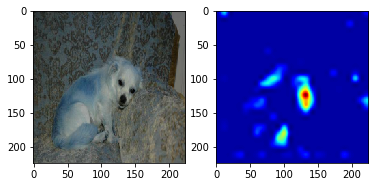

dog


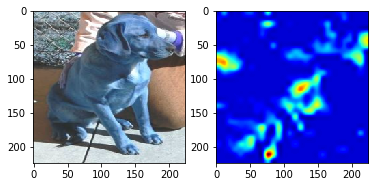

cat


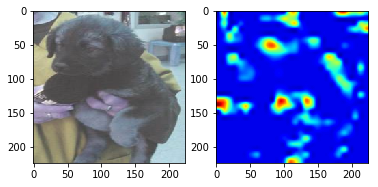

cat


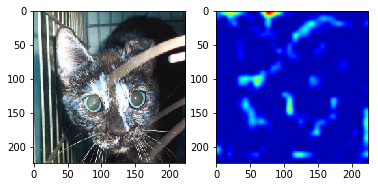

cat


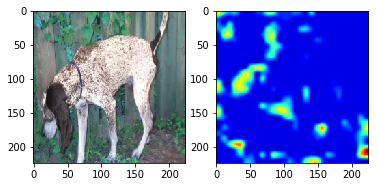

dog


In [55]:
for index in range(10):
    compare_original_heatmap(index)
    print(predictions_labels[index])